# Contents

## 01 Import libraries and data

## 02 Data preprocessing

### 02.1 Split data

### 02.2 Smoothen data

## 03 Visualise overall price development

### 03.1 Visualise trend, seasonality and noise

### 03.2 Stationarise data

### 03.3 Test for autocorrelations

## 04 Bonus task: forecasting (ARIMA model)

### 04.1 Define parameters

### 04.2 Split data

### 04.3 Run and fit ARIMA model

### 04.4 Iterating forecast

# 01 Import libraries and data

While I have installed the quandl library in order to follow along with the example of the Federal Reserve Economic Data from Exercise 6.6, I have not imported the library below as I will be working with the NYC property sales data and the time component that is included in this dataset.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

In [2]:
# Disable deprecation warnings
warnings.filterwarnings('ignore')

In [3]:
# Define path variable
path = r'/Users/DanielaDietmayr/Library/CloudStorage/OneDrive-Personal/2023-05-07_NYC property sales/02_Data/02_Prepared data'

# Import data
df = pd.read_pickle(os.path.join(path, '2023-06-18_df.pkl'))

In [4]:
# Get dimensions of df
df.shape

(1665722, 20)

In [5]:
# Get columns and datatypes
df.dtypes

borough_code                              object
neighborhood                              object
building_class_category                   object
tax_class_at_present                      object
easement                                  object
building_class_at_present                 object
residential_units                          int64
commercial_units                           int64
total_units                                int64
land_square_feet                         float64
gross_square_feet                        float64
year_built                                 int64
tax_class_at_time_of_sale                 object
building_class_at_time_of_sale            object
sale_price                               float64
sale_date                         datetime64[ns]
sale_price_flag                           object
borough_name                              object
age_cluster                               object
price_cluster                             object
dtype: object

In [6]:
# Inspect head of df
df.head()

,borough_code,neighborhood,building_class_category,tax_class_at_present,easement,building_class_at_present,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,sale_price_flag,borough_name,age_cluster,price_cluster
0,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,NaN,A5,1,0,1,3654.0,910.0,2002,1,A5,764000.0,2022-06-30,nan,Staten Island,medium-age building,very low-priced
1,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,NaN,A1,1,0,1,7654.0,2277.0,1980,1,A1,1098000.0,2022-08-19,nan,Staten Island,medium-age building,very low-priced
3,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,NaN,A2,1,0,1,8190.0,1528.0,1970,1,A2,890000.0,2022-01-03,nan,Staten Island,new building,very low-priced
5,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,NaN,A1,1,0,1,5999.0,3250.0,1989,1,A1,1050000.0,2022-08-31,nan,Staten Island,medium-age building,very low-priced
6,5,ANNADALE,01 ONE FAMILY DWELLINGS,1,NaN,A1,1,0,1,6200.0,2580.0,1975,1,A1,910000.0,2022-04-05,nan,Staten Island,new building,very low-priced


# 02 Data preprocessing

I seek to investigate the development of property prices from 2003 - 2023 and find out how prices developed over time. This requires some preprocessing of the data: 1) Split the data into ownership transfers and actual sales; continue with actual sales. 2) Split sales into five boroughs. 3) Smoothen data to obtain average sale prices at regular intervals for the five boroughs.

While I will prepare the data for looking into price development in NYC's five boroughs (i.e. I will split and smoothen it), I will only visualise overall price development in this script in order not to make the script too long and too heavy.

## 02.1 Split data

In [7]:
# Split data into ownership transfers and actual sales
df_ot = df.loc[df['sale_price']==0]
df_s = df.loc[df['sale_price']!=0]

In [8]:
# Get dimensions of ownership transfers
df_ot.shape

(483934, 20)

In [9]:
# Get dimensions of sales
df_s.shape

(1181788, 20)

In [10]:
# Double-check correct split of df
len(df) == len(df_ot) + len(df_s)

True

In [11]:
# Split sales into NYC's five boroughs
bn = df_s.loc[df_s['borough_name'] == 'Brooklyn']
bx = df_s.loc[df_s['borough_name'] == 'Bronx']
ma = df_s.loc[df_s['borough_name'] == 'Manhattan']
qu = df_s.loc[df_s['borough_name'] == 'Queens']
si = df_s.loc[df_s['borough_name'] == 'Staten Island']

In [12]:
# Get dimensions for Brooklyn
bn.shape

(301779, 20)

In [13]:
# Double-check correct split
len(df_s) == len(bn)+len(bx)+len(ma)+len(qu)+len(si)

True

## 02.2 Smoothen data

In [14]:
# Create list of irrelevant columns to drop
drop_cols = ['borough_code', 'neighborhood', 'building_class_category', 'tax_class_at_present', 'easement', 'building_class_at_present', 'residential_units', 'commercial_units', 'total_units', 'land_square_feet', 'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale', 'building_class_at_time_of_sale', 'sale_price_flag', 'borough_name', 'age_cluster', 'price_cluster']

# Drop irrelevant columns from dataframes for all sales and from dataframes for boroughs
df_s = df_s.drop(columns = drop_cols)
bn = bn.drop(columns = drop_cols)
bx = bx.drop(columns = drop_cols)
ma = ma.drop(columns = drop_cols)
qu = qu.drop(columns = drop_cols)
si = si.drop(columns = drop_cols)

In [15]:
# Convert sale_date to index in dataframes
df_s = df_s.set_index('sale_date')
bn = bn.set_index('sale_date')
bx = bx.set_index('sale_date')
ma = ma.set_index('sale_date')
qu = qu.set_index('sale_date')
si = si.set_index('sale_date')

In [16]:
# Get montly average price and store data in new dataframes
df_s_series = df_s.resample('M').mean()
bn_series = bn.resample('M').mean()
bx_series = bx.resample('M').mean()
ma_series = ma.resample('M').mean()
qu_series = qu.resample('M').mean()
si_series = si.resample('M').mean()

# 03 Visualise overall price development

In [17]:
# Set styling option for plots
plt.style.use('ggplot')

In [18]:
# Get curret directory
os.getcwd()

'/Users/DanielaDietmayr/Library/CloudStorage/OneDrive-Personal/2023-05-07_NYC property sales/03_Scripts'

In [19]:
# Change current directory in preparation for saving visuals
os.chdir('/Users/DanielaDietmayr/Library/CloudStorage/OneDrive-Personal/2023-05-07_NYC property sales/04_Analysis/01 Visuals')

## 03.1 Visualise trend, seasonality and noise

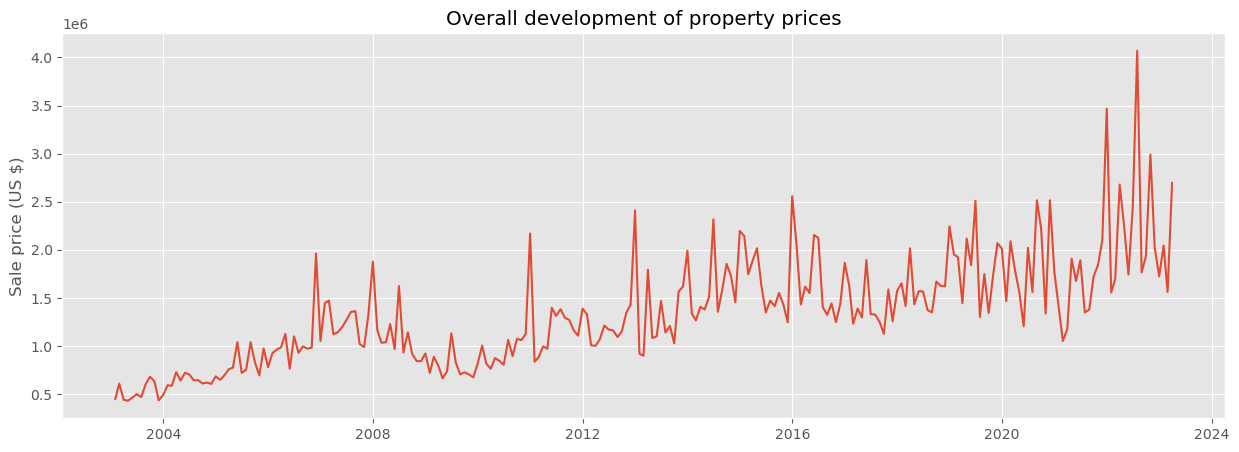

In [20]:
# Line chart for overall price development

# Set figure size and reduce quality of visual to dpi=100 to save RAM
plt.figure(figsize=(15,5), dpi=100)

# Add title and axis labels
plt.title('Overall development of property prices')
plt.ylabel('Sale price (US $)')

# Plot chart
plt.plot(df_s_series)

# Save visual
plt.savefig('2023-07-22_PriceDevOverall.png')

In [21]:
# Decompose overall price development
decomposition = sm.tsa.seasonal_decompose(df_s_series, model='additive')

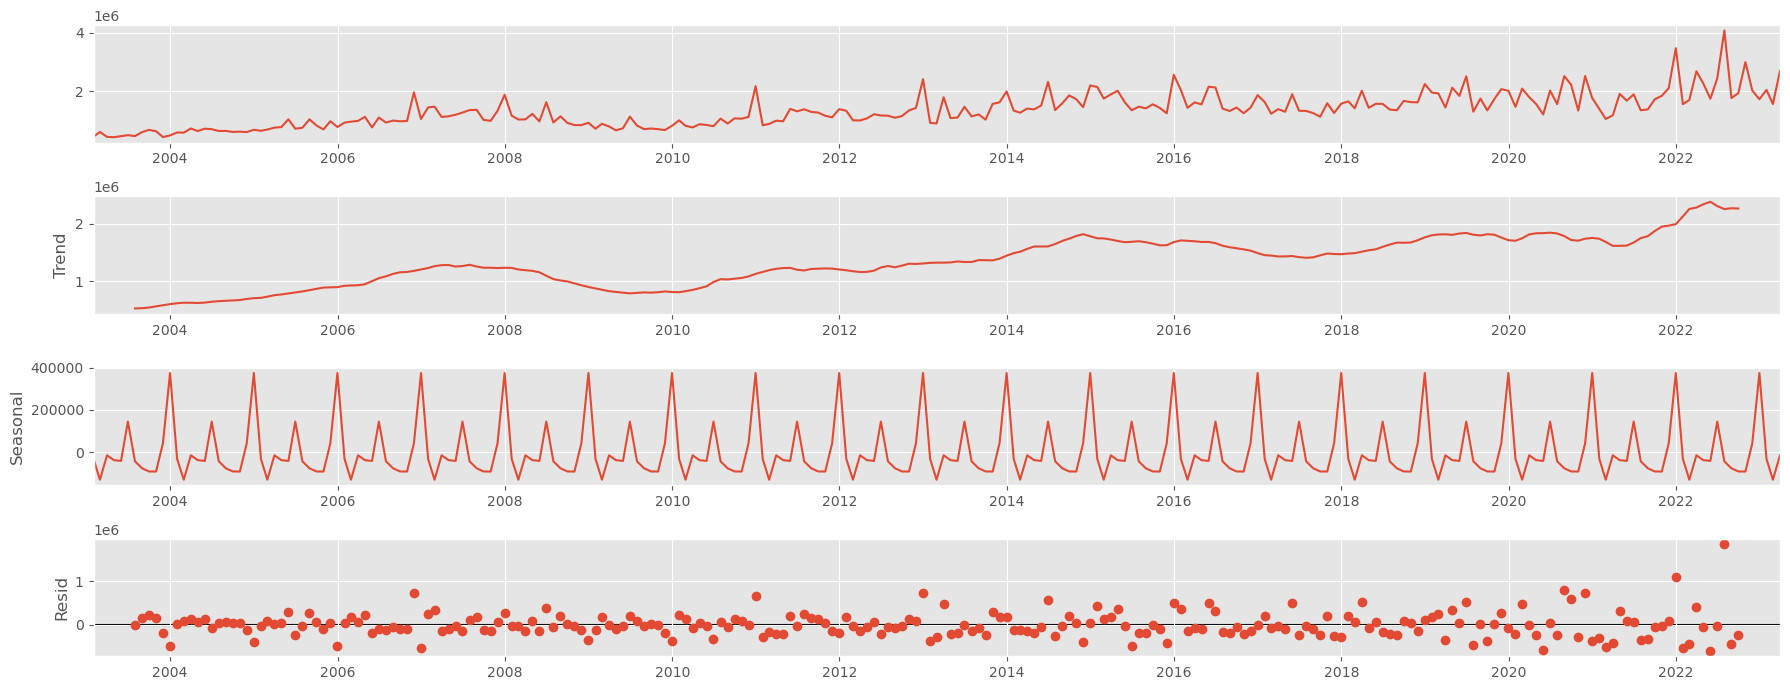

<Figure size 1800x700 with 0 Axes>

In [22]:
# Plot decomposed overall price development

# Import relevant function from pylab
from pylab import rcParams

# Define fixed size for all charts
rcParams['figure.figsize'] = 18,7

# Plot charts
decomposition.plot()
plt.show()

# Save visual
plt.savefig('2023-07-22_PriceDevOverall_decomp.png')

The trend chart shows that there is a dominant upward trend in sale prices despite some ups and downs over the years. Furthermore it appears that there could be cycles in the data: prices rise from 2003 to 2007, then fall until 2010. They then rise again until 2015, then fall until 2018. 

The seasonality chart shows that sale prices indeed follow a seasonal pattern with drops in sale prices at the beginning of the year and spikes towards the end of the year.

Lastly, the residual chart shows that there is quite some noise in the data. This was to be expected against the background of previous insights into the data which showed how broadly sale prices vary. 

In [23]:
# Test for stationarity with Dickey-Fuller test

# Import adfuller function from statsmodel
from statsmodels.tsa.stattools import adfuller

# Define function that prints correct output from array created with adfuller function
def dickey_fuller(timeseries):
    print('Dickey-Fuller stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test statistic', 'p-value', 'Number of lags used', 'Number of observations used'])
    for key,value in test[4].items():
        result['Critical value (%s)'%key] = value
    print(result)
    
# Apply test by using defined function on dataset
dickey_fuller(df_s_series['sale_price'])

Dickey-Fuller stationarity test:
Test statistic                  -1.636588
p-value                          0.464044
Number of lags used              6.000000
Number of observations used    236.000000
Critical value (1%)             -3.458366
Critical value (5%)             -2.873866
Critical value (10%)            -2.573339
dtype: float64


Null-hypothesis: a unit root is present in the data, i.e. data is non-stationary.
Alternative hypothesis: no unit root is present in the data, i.e. data is stationary.

Interpretation of results:
The p-value is higher than 0,05 which means that the test result is not significant. 
Furthermore, the test statistic is larger than the crtical values at each significance level. Hence, the null-hypothesis cannot be rejected.

This confirms what was already visible in the trend chart: statistical measures of sale prices do not remain constant over time. 

## 03.2 Stationarise data

In [24]:
# Difference data
df_s_series_diff = df_s_series - df_s_series.shift(1)

# Remove missing values in preparation for another Dickey-Fuller test
df_s_series_diff.dropna(inplace=True)

# Inspect head of differenced data
df_s_series_diff.head()

,sale_price
sale_date,
2003-02-28,159047.431318
2003-03-31,-167533.434166
2003-04-30,-10488.249541
2003-05-31,33784.228147
2003-06-30,35499.397798


In [25]:
# Apply Dickey-Fuller test on differenced data
dickey_fuller(df_s_series_diff['sale_price'])

Dickey-Fuller stationarity test:
Test statistic                -1.080281e+01
p-value                        1.997734e-19
Number of lags used            5.000000e+00
Number of observations used    2.360000e+02
Critical value (1%)           -3.458366e+00
Critical value (5%)           -2.873866e+00
Critical value (10%)          -2.573339e+00
dtype: float64


Null-hypothesis: a unit root is present in the data, i.e. data is non-stationary.
Alternative hypothesis: no unit root is present in the data, i.e. data is stationary.

Interpretation of results:
The p-value is smaller than 0.05, hence the test result is significant. 
Furthermore, the test statistic is smaller than the crtical values at each significance level. Hence, the null-hypothesis can be rejected and stationarity was successfully enforced on the data.

To confirm this, the differenced data will be plotted below.

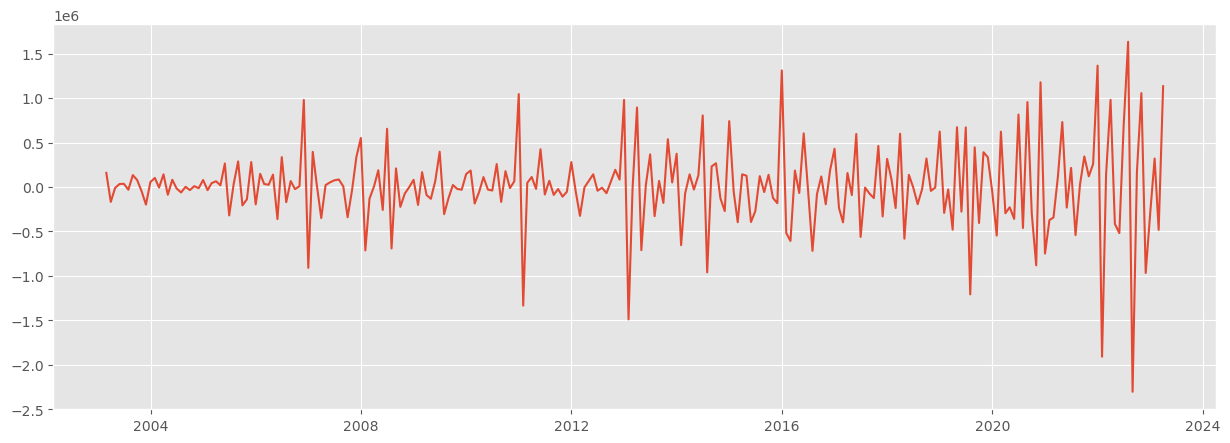

In [26]:
# Plot differenced data

# Set figure size and quality of visual
plt.figure(figsize=(15,5), dpi=100)

# Plot chart
plt.plot(df_s_series_diff)

# Save visual
plt.savefig('2023-07-22_PriceDevOverall_diff1.png')

While the plot of the difference data shows that there is still a lot of noise in the data, it is also visible that the mean is now relatively stable over time.

## 03.3 Test for autocorrelations

In [27]:
# Import auto-correlation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

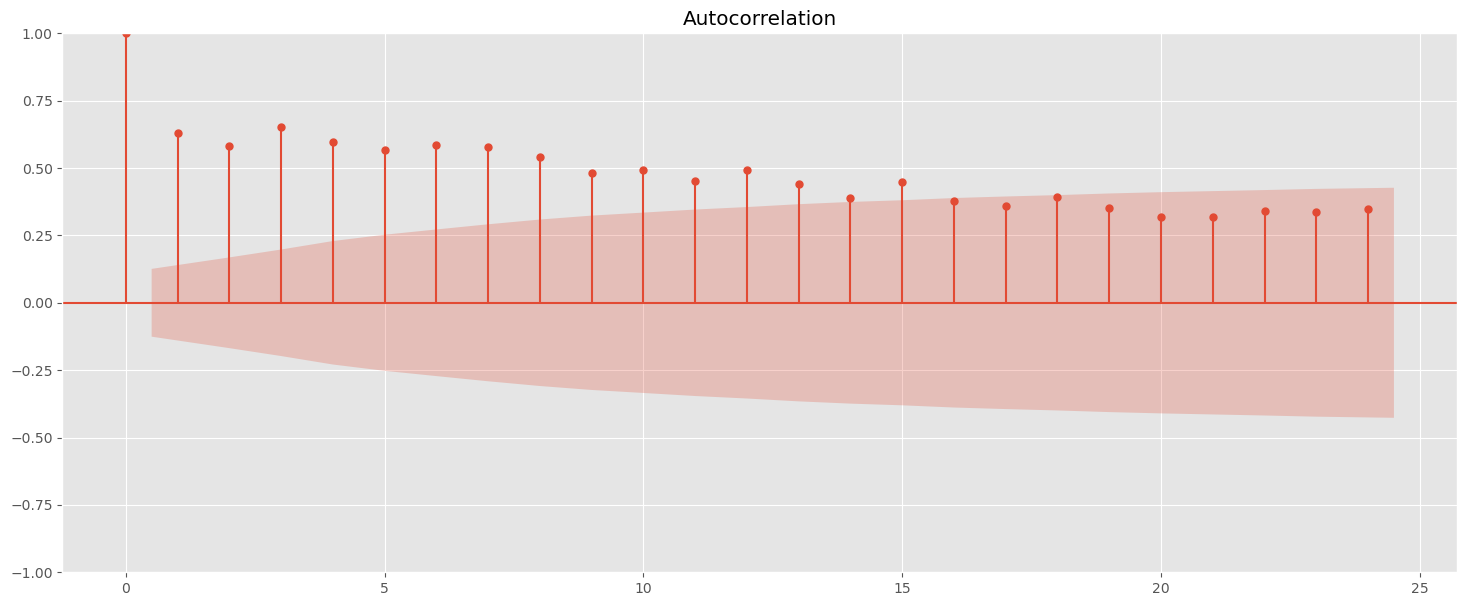

<Figure size 1800x700 with 0 Axes>

In [28]:
# Plot auto-correlation before differencing
plot_acf(df_s_series)
plt.show()

# Save visual
plt.savefig('2023-07-22_PriceDevOverall_autocorr-original.png')

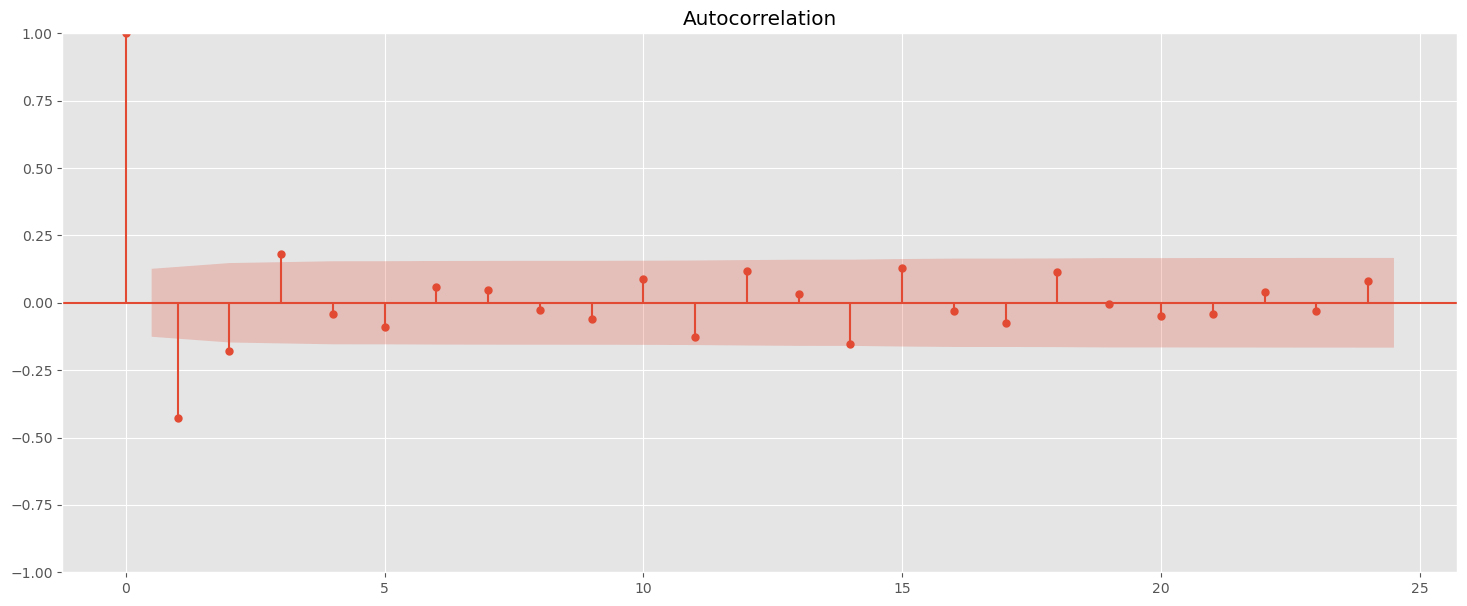

<Figure size 1800x700 with 0 Axes>

In [29]:
# Plot auto-correlation after differencing
plot_acf(df_s_series_diff)
plt.show()

# Save visual
plt.savefig('2023-07-22_PriceDevOverall_autocorr-diff.png')

Before differencing, the data was clearly auto-correlated with ca. 2/3 of the lags going beyond the confidence interval. 

After differencing, there are still 4 lags that go beyond the confidence interval, which is a sufficiently low number to consider the data ready to be used for forecasting. 

# 04 Bonus task: forecasting (ARIMA model)

## 04.1 Define parameters

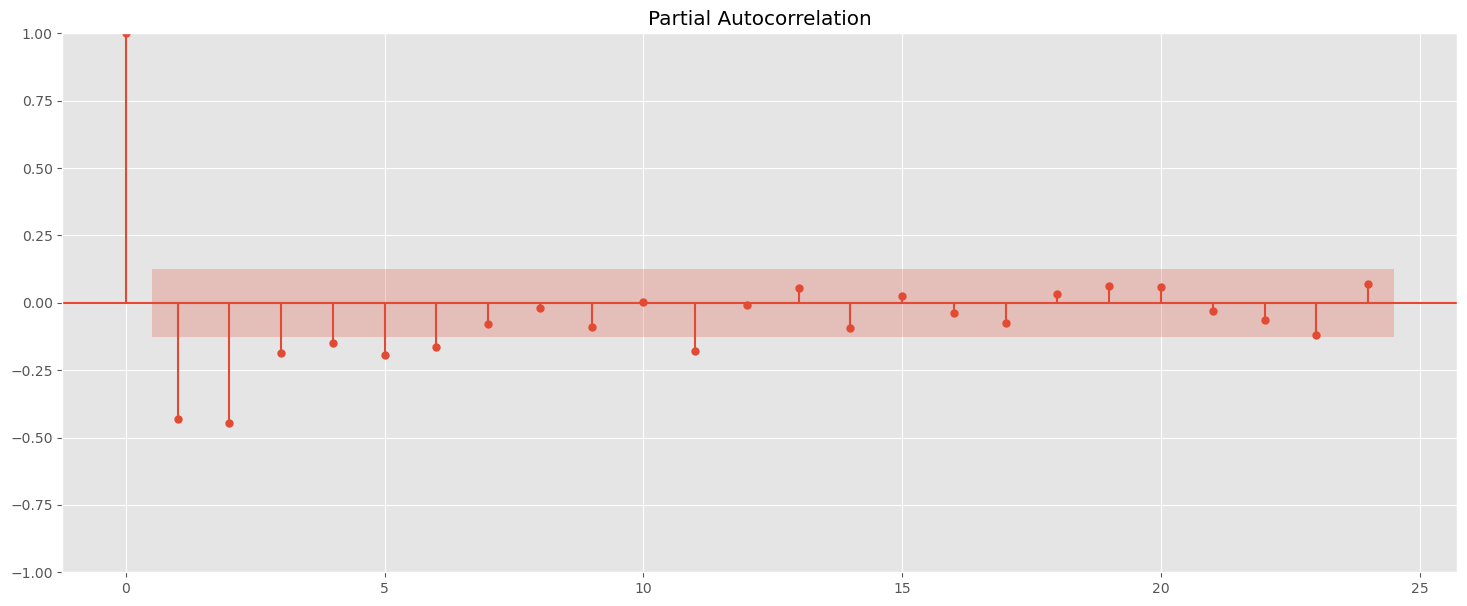

<Figure size 4500x4500 with 0 Axes>

In [30]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(df_s_series_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

One bar is highly positive. To compensate for it, p will be set to 1.

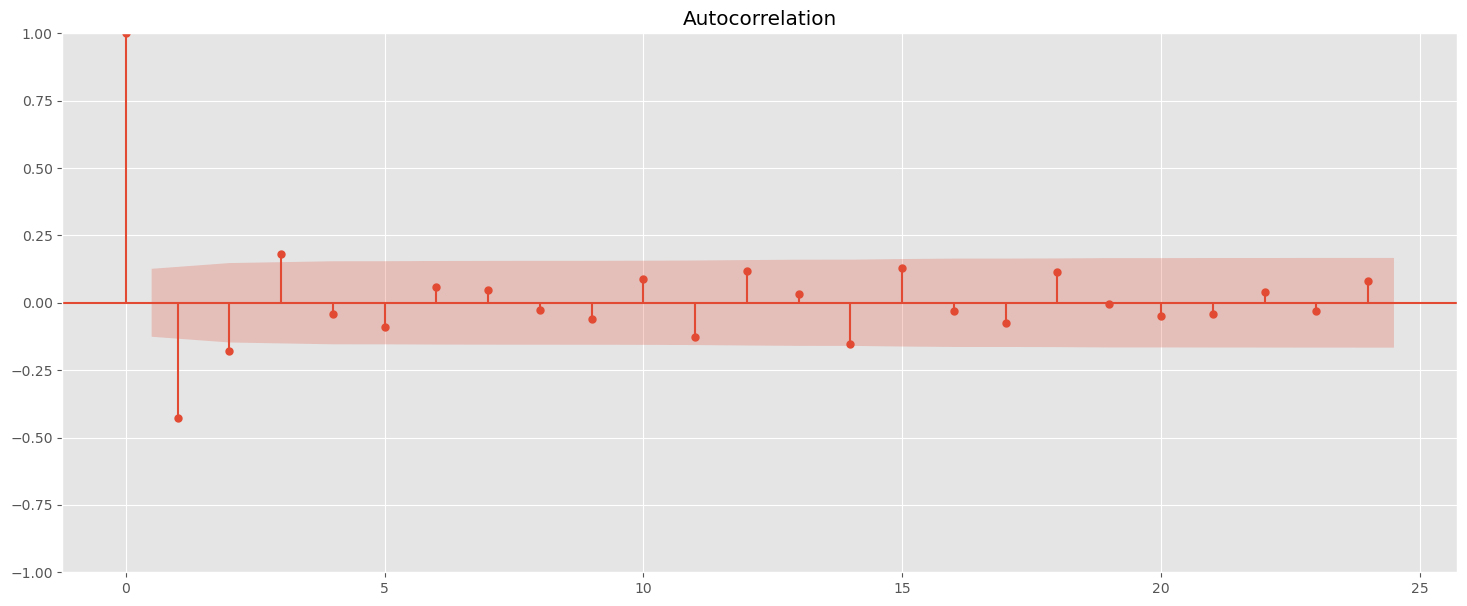

<Figure size 1500x500 with 0 Axes>

In [31]:
# Plot autocorrelations to determine parameter q
plot_acf(df_s_series_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

Four autocorrelations are significant. Following a conservative approach, q will be set to 2.

## 04.2 Split data

In [32]:
# Get dimensions of df_s_series_diff
df_s_series_diff.shape

(242, 1)

In [33]:
# Split the data (aiming for a 80/20 split)
train = df_s_series_diff['sale_price'][:190]
test = df_s_series_diff['sale_price'][189:]

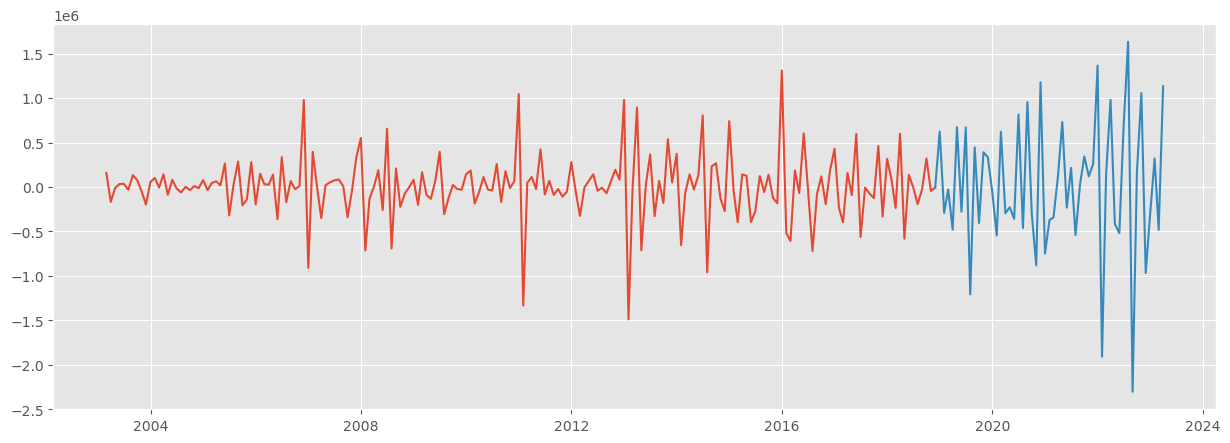

In [34]:
# Plot both sets in order to see the split
plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [35]:
# Get dimensions of train
train.shape

(190,)

In [36]:
# Get dimensions of test
test.shape

(53,)

## 04.3 Run and fit ARIMA model

In [37]:
# Import relevant model
from statsmodels.tsa.api import ARIMA 

                               SARIMAX Results                                
Dep. Variable:             sale_price   No. Observations:                  190
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2650.257
Date:                Tue, 22 Aug 2023   AIC                           5308.514
Time:                        20:53:08   BIC                           5321.481
Sample:                    02-28-2003   HQIC                          5313.767
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0306      0.133      0.229      0.819      -0.230       0.292
ma.L1         -1.7930      0.089    -20.216      0.000      -1.967      -1.619
ma.L2          0.7955      0.086      9.228      0.0

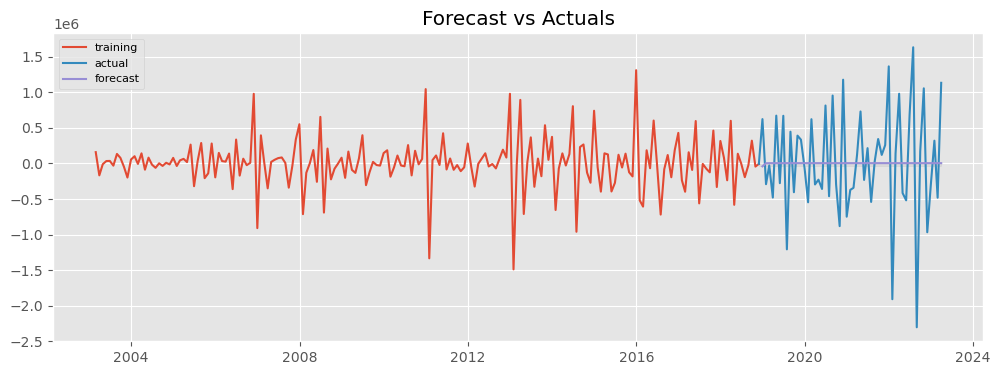

In [38]:
model = ARIMA(train, order=(1, 1, 2)) 
fitted = model.fit() 
print(fitted.summary()) # Check model summary

# Forecast - fc, se, conf
fc = fitted.forecast(53, alpha=0.05) # 95% confidence interval --> alpha = 0.05; 53 is the shape of the test set

# Make into pandas series 
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve 
lower_series = pd.Series(fc[0], index=test.index) # lower bound of the confidence interval 
upper_series = pd.Series(fc[52], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval#
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# 04.4 Iterating forecast

                               SARIMAX Results                                
Dep. Variable:             sale_price   No. Observations:                  190
Model:               ARIMA(20, 1, 16)   Log Likelihood               -2615.735
Date:                Tue, 22 Aug 2023   AIC                           5305.470
Time:                        21:22:37   BIC                           5425.414
Sample:                    02-28-2003   HQIC                          5354.062
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6583      3.488     -0.475      0.635      -8.496       5.179
ar.L2         -1.7308      8.107     -0.214      0.831     -17.620      14.158
ar.L3         -1.8280     12.263     -0.149      0.8

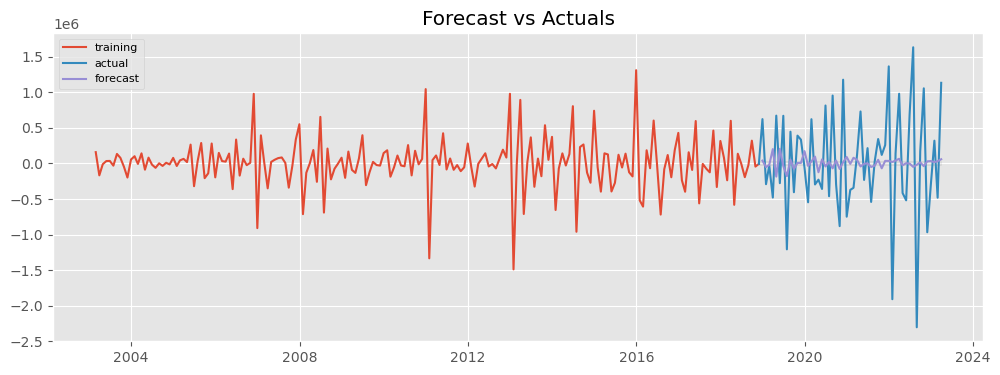

In [44]:
model = ARIMA(train, order=(20, 1, 16)) 
fitted = model.fit() 
print(fitted.summary()) # Check model summary

# Forecast - fc, se, conf
fc = fitted.forecast(53, alpha=0.05) # 95% confidence interval --> alpha = 0.05; 53 is the shape of the test set

# Make into pandas series 
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve 
lower_series = pd.Series(fc[0], index=test.index) # lower bound of the confidence interval 
upper_series = pd.Series(fc[52], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval#
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Continuing iterating is not advisable. Instead, it's better to go back to the step of smoothening the data and average across quarters or even years (instead of months). However, this is not done here as the time series will be visualised using tableau to create a storyboard. 